# Azure AI Search text splitter data chunking example

This notebook uses the Text Split skill in Azure AI Search to chunk text. This approach takes a dependency on indexers and skillsets.

The notebook complements the [Chunking large documents for vector search solutions](https://learn.microsoft.com/azure/search/vector-search-how-to-chunk-document) article in the Azure AI Search documentation.

### Set up a Python virtual environment in Visual Studio Code

1. Open the Command Palette (Ctrl+Shift+P).
1. Search for **Python: Create Environment**.
1. Select **Venv**.
1. Select a Python interpreter. Choose 3.10 or later.

It can take a minute to set up. If you run into problems, see [Python environments in VS Code](https://code.visualstudio.com/docs/python/environments).

### Install packages

In [ ]:
%pip install --quiet -r requirements.txt

### Load .env file (Copy .env-sample to .env and update accordingly)

In [1]:
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential
from azure.core.credentials import AzureKeyCredential
import os

load_dotenv() # take environment variables from .env.

search_endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
search_index = os.environ["AZURE_SEARCH_INDEX"]
search_datasource = os.environ["AZURE_SEARCH_DATASOURCE"]
search_skillset = os.environ["AZURE_SEARCH_SKILLSET"]
search_indexer = os.environ["AZURE_SEARCH_INDEXER"]
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
azure_openai_embedding_deployment_id = os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT_ID"]
blob_container = os.environ["AZURE_BLOB_CONTAINER"]
blob_connection_string = os.environ["AZURE_BLOB_CONNECTION_STRING"]
blob_account_url = os.environ["AZURE_BLOB_ACCOUNT_URL"]

search_credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"]) if len(os.environ["AZURE_SEARCH_ADMIN_KEY"]) > 0 else DefaultAzureCredential()
azure_openai_key = os.environ["AZURE_OPENAI_KEY"] if len(os.environ["AZURE_OPENAI_KEY"]) > 0 else None

### Upload sample PDF for chunking

In [2]:
from azure.storage.blob import BlobServiceClient

def open_blob_client():
    # Set max_block_size and max_single_put_size due to large PDF transfers
    # See https://learn.microsoft.com/azure/storage/blobs/storage-blobs-tune-upload-download-python
    if not blob_connection_string.startswith("ResourceId"):
        return BlobServiceClient.from_connection_string(
            blob_connection_string,
            max_block_size=1024*1024*8, # 8 MiB
            max_single_put_size=1024*1024*8 # 8 MiB
        )
    return BlobServiceClient(
        account_url=blob_account_url,
        credential=DefaultAzureCredential(),
        max_block_size=1024*1024*8, # 8 MiB
        max_single_put_size=1024*1024*8 # 8 MiB
    )

blob_client = open_blob_client()
container_client = blob_client.get_container_client(blob_container)
if not container_client.exists():
    container_client.create_container()

file_path = os.path.join("data", "earth_at_night_508.pdf")
blob_name = os.path.basename(file_path)
blob_client = container_client.get_blob_client(blob_name)
if not blob_client.exists():
    with open(file_path, "rb") as f:
        blob_client.upload_blob(data=f, overwrite=True)

### Setup sample resources for chunking

In [3]:
from azure.search.documents.indexes import SearchIndexClient, SearchIndexerClient
from lib.common import (
    create_search_index,
    create_search_datasource,
    create_search_skillset,
    create_search_indexer
)

search_index_client = SearchIndexClient(endpoint=search_endpoint, credential=search_credential)
index = create_search_index(
    search_index,
    azure_openai_endpoint,
    azure_openai_embedding_deployment_id,
    azure_openai_key
)
search_index_client.create_or_update_index(index)

search_indexer_client = SearchIndexerClient(endpoint=search_endpoint, credential=search_credential)

data_source = create_search_datasource(
    search_datasource,
    blob_connection_string,
    blob_container
)
search_indexer_client.create_or_update_data_source_connection(data_source)

skillset = create_search_skillset(
    search_skillset,
    search_index,
    azure_openai_endpoint,
    azure_openai_embedding_deployment_id,
    azure_openai_key,
    text_split_mode='pages',
    maximum_page_length=2000,
    page_overlap_length=500
)
search_indexer_client.create_or_update_skillset(skillset)

indexer = create_search_indexer(
    indexer_name=search_indexer,
    index_name=search_index,
    datasource_name=search_datasource,
    skillset_name=search_skillset
)
search_indexer_client.create_or_update_indexer(indexer)
search_indexer_client.run_indexer(search_indexer)

print("Running indexer")


Running indexer


### Show chunk character length and token length histogram

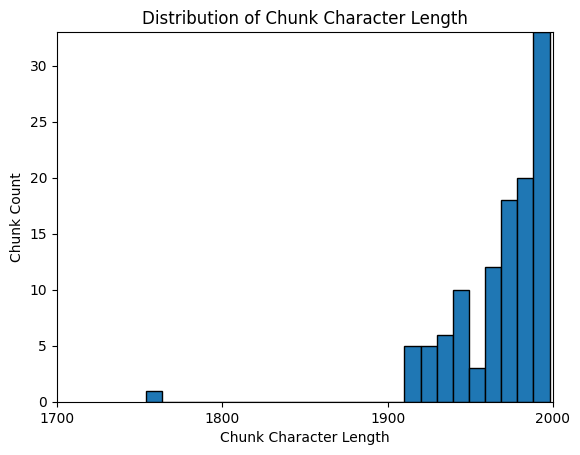

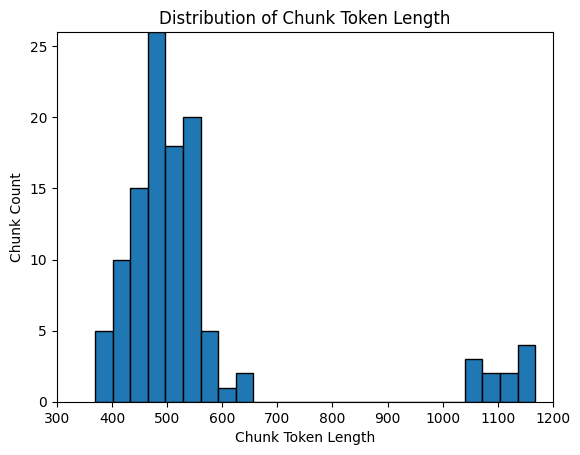

In [6]:
%matplotlib inline
from lib.common import (
    get_chunks,
    get_token_length,
    plot_chunk_histogram
)

search_client = search_index_client.get_search_client(search_index)
chunks = get_chunks(search_client)

plot_chunk_histogram(chunks, length_fn=len, title="Distribution of Chunk Character Length", xlabel="Chunk Character Length")
plot_chunk_histogram(chunks, length_fn=get_token_length, title="Distribution of Chunk Token Length", xlabel="Chunk Token Length")